# Binary classification with logistic regression

- Regression is the hammer we reach for when we want to answer how much? or how many? questions.
- In industry, we’re more often interested in **making categorical assignments**, which is called **classification**.
- binary classification: Let’s call our two categories the positive class y^i=1 and the negative class y^i=0.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mover>
    <mi>y</mi>
    <mo stretchy="false">&#x005E;<!-- ^ --></mo>
  </mover>
  <mo>=</mo>
  <mi>&#x03C3;<!-- σ --></mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi mathvariant="bold-italic">w</mi>
    <mi>T</mi>
  </msup>
  <mi mathvariant="bold-italic">x</mi>
  <mo>+</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
  <mo>.</mo>
</math>

- The sigmoid function σ, sometimes called a squashing function or a logistic function - thus the name logistic regression - maps a real-valued input to the range 0 to 1. 
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

-Because the sigmoid outputs a value between 0 and 1, it’s more reasonable to think of it as a probability. Note that an input of 0 gives a value of .5

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

In [2]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

In [4]:
x = nd.arange(-5, 5, 1)
y = logistic(x)
x, y

(
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]
 <NDArray 10 @cpu(0)>, 
 [0.00669285 0.01798621 0.04742587 0.11920292 0.26894143 0.5
  0.7310586  0.880797   0.95257413 0.98201376]
 <NDArray 10 @cpu(0)>)

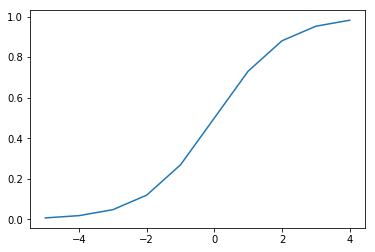

In [5]:
plt.plot(x.asnumpy(), y.asnumpy())

In [10]:
logistic(nd.array([0]))


[0.5]
<NDArray 1 @cpu(0)>

## Binary cross-entropy loss

- log loss (binary cross entropy)
- if $y_i$ is 1 or 0 ...
- a special case of cross-entropy
$$
\ell (\boldsymbol{y}, \boldsymbol{\hat{y}}) =  - \sum_{i=1}^n y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).
$$



In [13]:
%cd ~/repo/deep-learning
%pwd

/home/zhenglai/repo/deep-learning


'/home/zhenglai/repo/deep-learning'

In [14]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

with open('data/a1a.train') as f:
    train_raw = f.read()

with open('data/a1a.test') as f:
    test_raw = f.read()

In [16]:
train_raw[0], test_raw[0]

('-', '-')

In [30]:
def process_data(raw_data):
    train_lines = raw_data.splitlines()
    num_examples = len(train_lines)
    num_features = 123
    X = nd.zeros((num_examples, num_features), ctx=data_ctx)
    Y = nd.zeros((num_examples, 1), ctx=data_ctx)
    for i, line in enumerate(train_lines):
        tokens = line.split()
        label = (int(tokens[0]) + 1 ) / 2 # change label from {-1, 1} to {0, 1}
        Y[i] = label
        for token in tokens[1:]:
            index = int(token[:-2]) - 1
            X[i, index] = 1
    return X, Y
            

In [32]:
X_train, Y_train = process_data(train_raw)
X_test, Y_test = process_data(test_raw)


In [33]:
X_train.shape, Y_train.shape,  X_test.shape, Y_test.shape

((1605, 123), (1605, 1), (30956, 123), (30956, 1))

In [35]:
nd.sum(Y_train) / len(Y_train), nd.sum(Y_test) / len(Y_test)

(
 [0.24610592]
 <NDArray 1 @cpu(0)>, 
 [0.24053495]
 <NDArray 1 @cpu(0)>)

In [37]:
batch_size = 64
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_train, Y_train),
                                   batch_size=batch_size,
                                   shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_test, Y_test),
                                  batch_size=batch_size,
                                  shuffle=True)

In [38]:
net = gluon.nn.Dense(1, in_units=123)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

In [40]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [44]:
def log_loss(y_pred, y_true):
    yhat = logistic(y_pred)
    return -nd.nansum(y_true * nd.log(yhat) + (1 - y_true) * nd.log(1 - yhat))


In [61]:
nrof_epoch = 1500
losses = []
nrof_examples = len(X_train)

for e in range(nrof_epoch):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            y_pred = net(data)
            loss = log_loss(y_pred, label)
            
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    losses.append(cumulative_loss)
    print('Epoch {}, loss: {}'.format(e, cumulative_loss))

Epoch 0, loss: 529.7440814971924
Epoch 1, loss: 529.7337665557861
Epoch 2, loss: 529.6576271057129


Epoch 3, loss: 529.6718997955322
Epoch 4, loss: 529.6519181728363
Epoch 5, loss: 529.6117503643036


Epoch 6, loss: 529.606360912323
Epoch 7, loss: 529.545517206192
Epoch 8, loss: 529.54570043087
Epoch 9, loss: 529.4981852173805


Epoch 10, loss: 529.5292819142342
Epoch 11, loss: 529.5162823200226
Epoch 12, loss: 529.441172003746
Epoch 13, loss: 529.4758333563805


Epoch 14, loss: 529.4283218383789
Epoch 15, loss: 529.3255271911621
Epoch 16, loss: 529.318289399147
Epoch 17, loss: 529.2971429824829


Epoch 18, loss: 529.2711372375488
Epoch 19, loss: 529.2630590200424
Epoch 20, loss: 529.2225176095963
Epoch 21, loss: 529.1926245689392


Epoch 22, loss: 529.2300015687943
Epoch 23, loss: 529.1673166751862
Epoch 24, loss: 529.1420912742615


Epoch 25, loss: 529.1220030784607
Epoch 26, loss: 529.1118512153625
Epoch 27, loss: 529.0734310150146


Epoch 28, loss: 529.0342526435852
Epoch 29, loss: 529.0005893707275
Epoch 30, loss: 529.0246284008026


Epoch 31, loss: 528.9980469346046
Epoch 32, loss: 528.9736700057983
Epoch 33, loss: 528.9613733291626
Epoch 34, loss: 528.904002904892


Epoch 35, loss: 528.913078546524
Epoch 36, loss: 528.851771235466
Epoch 37, loss: 528.8209407329559


Epoch 38, loss: 528.8062269687653
Epoch 39, loss: 528.8185213208199
Epoch 40, loss: 528.7967026233673


Epoch 41, loss: 528.7426298260689
Epoch 42, loss: 528.6852924823761
Epoch 43, loss: 528.7202059030533
Epoch 44, loss: 528.6958192586899


Epoch 45, loss: 528.6221777200699
Epoch 46, loss: 528.658650636673
Epoch 47, loss: 528.5954713821411


Epoch 48, loss: 528.5413163155317
Epoch 49, loss: 528.4781832695007
Epoch 50, loss: 528.4941532611847
Epoch 51, loss: 528.4673085212708


Epoch 52, loss: 528.4630966186523
Epoch 53, loss: 528.4075399637222
Epoch 54, loss: 528.4191741943359
Epoch 55, loss: 528.4323637485504


Epoch 56, loss: 528.392258644104
Epoch 57, loss: 528.3514596819878
Epoch 58, loss: 528.3214153647423


Epoch 59, loss: 528.2898440361023
Epoch 60, loss: 528.3134379386902
Epoch 61, loss: 528.29031676054
Epoch 62, loss: 528.2369115352631


Epoch 63, loss: 528.2236812114716
Epoch 64, loss: 528.2336438894272
Epoch 65, loss: 528.1677303612232
Epoch 66, loss: 528.1402431130409


Epoch 67, loss: 528.1044853925705
Epoch 68, loss: 528.0908021330833
Epoch 69, loss: 528.0814626216888
Epoch 70, loss: 528.0819071531296


Epoch 71, loss: 527.9957315921783
Epoch 72, loss: 528.0566719174385
Epoch 73, loss: 527.9649755358696
Epoch 74, loss: 527.9732210636139


Epoch 75, loss: 527.9087871611118
Epoch 76, loss: 527.9148254394531
Epoch 77, loss: 527.8830091953278
Epoch 78, loss: 527.8618871569633


Epoch 79, loss: 527.8546062707901
Epoch 80, loss: 527.7883660793304
Epoch 81, loss: 527.8095734119415
Epoch 82, loss: 527.7283799648285


Epoch 83, loss: 527.767049074173
Epoch 84, loss: 527.7081413269043
Epoch 85, loss: 527.683131814003
Epoch 86, loss: 527.6881699562073


Epoch 87, loss: 527.6803553104401
Epoch 88, loss: 527.6139372587204
Epoch 89, loss: 527.6540505886078
Epoch 90, loss: 527.6079419851303


Epoch 91, loss: 527.6160048246384
Epoch 92, loss: 527.5757772922516
Epoch 93, loss: 527.5282329916954
Epoch 94, loss: 527.4966228604317


Epoch 95, loss: 527.4499905109406
Epoch 96, loss: 527.4401381015778
Epoch 97, loss: 527.4013137817383
Epoch 98, loss: 527.4157332777977


Epoch 99, loss: 527.4134423732758
Epoch 100, loss: 527.4072535037994
Epoch 101, loss: 527.3197309970856
Epoch 102, loss: 527.304305255413


Epoch 103, loss: 527.3571489453316
Epoch 104, loss: 527.2658638954163
Epoch 105, loss: 527.2582442760468
Epoch 106, loss: 527.2528898715973


Epoch 107, loss: 527.2273057103157
Epoch 108, loss: 527.2421786785126
Epoch 109, loss: 527.1322690248489


Epoch 110, loss: 527.1283179521561
Epoch 111, loss: 527.1159060001373
Epoch 112, loss: 527.12961769104
Epoch 113, loss: 527.067641377449


Epoch 114, loss: 527.0929476618767
Epoch 115, loss: 527.0105978250504
Epoch 116, loss: 527.0337803959846
Epoch 117, loss: 526.995433986187


Epoch 118, loss: 526.947741985321
Epoch 119, loss: 526.9337139129639
Epoch 120, loss: 527.0254065990448
Epoch 121, loss: 526.9135288000107


Epoch 122, loss: 526.8847329616547
Epoch 123, loss: 526.8261337280273
Epoch 124, loss: 526.859073728323
Epoch 125, loss: 526.8509492874146


Epoch 126, loss: 526.8361821174622
Epoch 127, loss: 526.7903065681458
Epoch 128, loss: 526.7973434925079
Epoch 129, loss: 526.7803058624268


Epoch 130, loss: 526.69706594944
Epoch 131, loss: 526.6902277469635
Epoch 132, loss: 526.7169015407562
Epoch 133, loss: 526.7050378322601


Epoch 134, loss: 526.6387053728104
Epoch 135, loss: 526.6750626564026
Epoch 136, loss: 526.602201461792
Epoch 137, loss: 526.6399331092834


Epoch 138, loss: 526.5564954727888
Epoch 139, loss: 526.5000156164169
Epoch 140, loss: 526.4929727315903
Epoch 141, loss: 526.5519129037857


Epoch 142, loss: 526.4658955335617
Epoch 143, loss: 526.4782447814941
Epoch 144, loss: 526.3822149857879
Epoch 145, loss: 526.3885536193848


Epoch 146, loss: 526.4115300178528
Epoch 147, loss: 526.3694529384375
Epoch 148, loss: 526.3806171119213
Epoch 149, loss: 526.3398683071136


Epoch 150, loss: 526.3273503482342
Epoch 151, loss: 526.3317399024963
Epoch 152, loss: 526.2620014548302


Epoch 153, loss: 526.3003828525543
Epoch 154, loss: 526.2371884584427
Epoch 155, loss: 526.2451823949814
Epoch 156, loss: 526.195440530777


Epoch 157, loss: 526.1791694164276
Epoch 158, loss: 526.1192879676819
Epoch 159, loss: 526.1483693122864
Epoch 160, loss: 526.1128113269806


Epoch 161, loss: 526.1187246441841
Epoch 162, loss: 526.0846719741821
Epoch 163, loss: 526.0696430206299
Epoch 164, loss: 526.058434009552


Epoch 165, loss: 526.0046671628952
Epoch 166, loss: 525.9959937036037
Epoch 167, loss: 526.0243950784206


Epoch 168, loss: 525.9690238237381
Epoch 169, loss: 525.9515644311905
Epoch 170, loss: 525.9298852682114


Epoch 171, loss: 525.9136912822723
Epoch 172, loss: 525.8947021961212
Epoch 173, loss: 525.8605589866638
Epoch 174, loss: 525.8585333824158


Epoch 175, loss: 525.8138357698917
Epoch 176, loss: 525.7679334878922
Epoch 177, loss: 525.7808637619019
Epoch 178, loss: 525.7158883810043


Epoch 179, loss: 525.7588243484497
Epoch 180, loss: 525.6720423698425
Epoch 181, loss: 525.6946252584457
Epoch 182, loss: 525.6894713640213


Epoch 183, loss: 525.6484454870224
Epoch 184, loss: 525.6708481311798
Epoch 185, loss: 525.6195983886719
Epoch 186, loss: 525.577905356884


Epoch 187, loss: 525.5397893190384
Epoch 188, loss: 525.5834798812866
Epoch 189, loss: 525.574249535799
Epoch 190, loss: 525.5774321556091


Epoch 191, loss: 525.5183943510056
Epoch 192, loss: 525.4687328338623
Epoch 193, loss: 525.4822731018066
Epoch 194, loss: 525.4305903911591


Epoch 195, loss: 525.3686321377754
Epoch 196, loss: 525.3957266807556
Epoch 197, loss: 525.3551145792007
Epoch 198, loss: 525.375951051712


Epoch 199, loss: 525.3117616176605
Epoch 200, loss: 525.3370940685272
Epoch 201, loss: 525.2967031002045


Epoch 202, loss: 525.2330393791199
Epoch 203, loss: 525.2267120480537
Epoch 204, loss: 525.2262382507324
Epoch 205, loss: 525.1910275220871


Epoch 206, loss: 525.2137866020203
Epoch 207, loss: 525.1488227844238
Epoch 208, loss: 525.1755219697952
Epoch 209, loss: 525.1272215247154


Epoch 210, loss: 525.1029162406921
Epoch 211, loss: 525.0716171264648
Epoch 212, loss: 525.170302271843
Epoch 213, loss: 525.0497796535492


Epoch 214, loss: 525.0960632562637
Epoch 215, loss: 524.9835457801819
Epoch 216, loss: 525.0002818107605
Epoch 217, loss: 525.0038063526154


Epoch 218, loss: 525.0178651809692
Epoch 219, loss: 524.9707072973251
Epoch 220, loss: 524.9362497329712
Epoch 221, loss: 524.9624676704407


Epoch 222, loss: 524.9104955196381
Epoch 223, loss: 524.8644770383835
Epoch 224, loss: 524.8692474365234
Epoch 225, loss: 524.8632742166519


Epoch 226, loss: 524.7578464746475
Epoch 227, loss: 524.7534699440002
Epoch 228, loss: 524.7833923101425
Epoch 229, loss: 524.7953284978867


Epoch 230, loss: 524.7456583976746
Epoch 231, loss: 524.7203888893127
Epoch 232, loss: 524.7098313570023
Epoch 233, loss: 524.6917061805725


Epoch 234, loss: 524.6710215806961
Epoch 235, loss: 524.6561905145645
Epoch 236, loss: 524.6691679954529
Epoch 237, loss: 524.6633303165436


Epoch 238, loss: 524.5977911949158
Epoch 239, loss: 524.6235171742737
Epoch 240, loss: 524.5566502064466
Epoch 241, loss: 524.5251259207726


Epoch 242, loss: 524.5209405422211
Epoch 243, loss: 524.4917095154524
Epoch 244, loss: 524.4662261009216
Epoch 245, loss: 524.5030890703201


Epoch 246, loss: 524.4006552696228
Epoch 247, loss: 524.4770169854164
Epoch 248, loss: 524.3930943012238
Epoch 249, loss: 524.3786601424217


Epoch 250, loss: 524.3450455665588
Epoch 251, loss: 524.3499678969383
Epoch 252, loss: 524.3519639968872


Epoch 253, loss: 524.2896661758423
Epoch 254, loss: 524.3273412585258
Epoch 255, loss: 524.3128080368042
Epoch 256, loss: 524.2484385967255


Epoch 257, loss: 524.2274572849274
Epoch 258, loss: 524.223626613617
Epoch 259, loss: 524.2484218478203
Epoch 260, loss: 524.2565447092056


Epoch 261, loss: 524.2244071960449
Epoch 262, loss: 524.176553606987
Epoch 263, loss: 524.2131124138832
Epoch 264, loss: 524.1203994750977


Epoch 265, loss: 524.1185641288757
Epoch 266, loss: 524.0626516342163
Epoch 267, loss: 524.0317611694336
Epoch 268, loss: 524.0300372838974


Epoch 269, loss: 524.0020834207535
Epoch 270, loss: 524.0449388027191
Epoch 271, loss: 523.9885753393173
Epoch 272, loss: 523.9967221021652


Epoch 273, loss: 523.9745469093323
Epoch 274, loss: 523.9792157411575
Epoch 275, loss: 523.9381073713303
Epoch 276, loss: 523.924778342247


Epoch 277, loss: 523.9715637564659
Epoch 278, loss: 523.8908267021179
Epoch 279, loss: 523.8536310195923
Epoch 280, loss: 523.8013577461243


Epoch 281, loss: 523.804368019104
Epoch 282, loss: 523.7601270675659
Epoch 283, loss: 523.8525655269623
Epoch 284, loss: 523.809096634388


Epoch 285, loss: 523.7414391636848
Epoch 286, loss: 523.7692179679871
Epoch 287, loss: 523.7052555084229
Epoch 288, loss: 523.6728942394257


Epoch 289, loss: 523.6932834386826
Epoch 290, loss: 523.6764246821404
Epoch 291, loss: 523.6222068071365
Epoch 292, loss: 523.6173415035009


Epoch 293, loss: 523.5674120336771
Epoch 294, loss: 523.6065919399261
Epoch 295, loss: 523.5998311042786
Epoch 296, loss: 523.5244407653809


Epoch 297, loss: 523.5362892150879
Epoch 298, loss: 523.5196781158447
Epoch 299, loss: 523.5380804538727
Epoch 300, loss: 523.4875339269638


Epoch 301, loss: 523.5306822061539
Epoch 302, loss: 523.4587054252625
Epoch 303, loss: 523.4468333721161
Epoch 304, loss: 523.4025855958462


Epoch 305, loss: 523.3936243057251


Epoch 306, loss: 523.3755089044571
Epoch 307, loss: 523.3639578819275
Epoch 308, loss: 523.3405079096556
Epoch 309, loss: 523.3485665917397


Epoch 310, loss: 523.3259952068329
Epoch 311, loss: 523.3125207424164
Epoch 312, loss: 523.2686824798584
Epoch 313, loss: 523.3079227209091


Epoch 314, loss: 523.2279670238495
Epoch 315, loss: 523.2640191316605
Epoch 316, loss: 523.2107096910477
Epoch 317, loss: 523.178618311882


Epoch 318, loss: 523.2668204307556
Epoch 319, loss: 523.1459693908691
Epoch 320, loss: 523.1487326025963
Epoch 321, loss: 523.1269925832748


Epoch 322, loss: 523.0947127342224
Epoch 323, loss: 523.10225507617
Epoch 324, loss: 523.0609855651855
Epoch 325, loss: 523.0608005523682


Epoch 326, loss: 522.9880439043045
Epoch 327, loss: 522.9639275074005
Epoch 328, loss: 522.960254073143
Epoch 329, loss: 522.9986492395401


Epoch 330, loss: 523.026153087616
Epoch 331, loss: 522.9305707216263
Epoch 332, loss: 522.9574115276337
Epoch 333, loss: 522.9704557657242


Epoch 334, loss: 522.8843042850494
Epoch 335, loss: 522.8635842204094
Epoch 336, loss: 522.8801236450672
Epoch 337, loss: 522.9147777557373


Epoch 338, loss: 522.8588871955872
Epoch 339, loss: 522.7860078811646
Epoch 340, loss: 522.7839725315571
Epoch 341, loss: 522.7508208751678


Epoch 342, loss: 522.7757341861725
Epoch 343, loss: 522.8119168877602
Epoch 344, loss: 522.7694880962372
Epoch 345, loss: 522.7333135604858


Epoch 346, loss: 522.7156885266304
Epoch 347, loss: 522.6306235790253
Epoch 348, loss: 522.6707639694214
Epoch 349, loss: 522.6692090034485


Epoch 350, loss: 522.6394081115723
Epoch 351, loss: 522.6440635621548
Epoch 352, loss: 522.6242069005966
Epoch 353, loss: 522.6230078935623


Epoch 354, loss: 522.6341904401779
Epoch 355, loss: 522.6723911762238
Epoch 356, loss: 522.5104945898056
Epoch 357, loss: 522.5363701581955


Epoch 358, loss: 522.4945334792137
Epoch 359, loss: 522.4911980628967
Epoch 360, loss: 522.4922285079956
Epoch 361, loss: 522.471849322319


Epoch 362, loss: 522.4641291871667
Epoch 363, loss: 522.4498962163925
Epoch 364, loss: 522.3988611698151
Epoch 365, loss: 522.3776363134384


Epoch 366, loss: 522.4011250138283
Epoch 367, loss: 522.3513658046722
Epoch 368, loss: 522.3179448843002
Epoch 369, loss: 522.3133924007416


Epoch 370, loss: 522.2891716957092
Epoch 371, loss: 522.2637218236923
Epoch 372, loss: 522.3034862875938


Epoch 373, loss: 522.2518107891083
Epoch 374, loss: 522.2244750261307
Epoch 375, loss: 522.2587075531483
Epoch 376, loss: 522.2240710258484


Epoch 377, loss: 522.1901364326477
Epoch 378, loss: 522.1463623046875
Epoch 379, loss: 522.1446068286896
Epoch 380, loss: 522.2083144187927


Epoch 381, loss: 522.1135495901108
Epoch 382, loss: 522.1449890136719
Epoch 383, loss: 522.1414141654968


Epoch 384, loss: 522.0812447071075
Epoch 385, loss: 522.0614042878151
Epoch 386, loss: 522.0516004562378
Epoch 387, loss: 522.0461866855621


Epoch 388, loss: 522.0235262513161
Epoch 389, loss: 521.9994177222252
Epoch 390, loss: 522.0209718942642
Epoch 391, loss: 521.9731465578079


Epoch 392, loss: 521.9824434518814
Epoch 393, loss: 521.954058766365
Epoch 394, loss: 521.873619556427
Epoch 395, loss: 521.871454000473


Epoch 396, loss: 521.8889107704163
Epoch 397, loss: 521.8733332157135
Epoch 398, loss: 521.8825746178627
Epoch 399, loss: 521.8364238739014


Epoch 400, loss: 521.8380455970764
Epoch 401, loss: 521.8923739790916
Epoch 402, loss: 521.8228542804718
Epoch 403, loss: 521.8037691116333


Epoch 404, loss: 521.7920843362808
Epoch 405, loss: 521.7746527194977
Epoch 406, loss: 521.7560595273972
Epoch 407, loss: 521.6920434236526


Epoch 408, loss: 521.6780632734299
Epoch 409, loss: 521.7553812563419
Epoch 410, loss: 521.6549030542374
Epoch 411, loss: 521.7030464708805


Epoch 412, loss: 521.6950277090073
Epoch 413, loss: 521.6357290744781
Epoch 414, loss: 521.6322574615479
Epoch 415, loss: 521.5962491035461


Epoch 416, loss: 521.601470708847
Epoch 417, loss: 521.5897325277328
Epoch 418, loss: 521.5289101600647
Epoch 419, loss: 521.57777094841


Epoch 420, loss: 521.5520998239517
Epoch 421, loss: 521.5072230100632
Epoch 422, loss: 521.5379989147186
Epoch 423, loss: 521.5150104761124


Epoch 424, loss: 521.4839634895325
Epoch 425, loss: 521.4419935941696
Epoch 426, loss: 521.4554966390133
Epoch 427, loss: 521.4224262237549


Epoch 428, loss: 521.4075620174408
Epoch 429, loss: 521.4789853096008
Epoch 430, loss: 521.3527913093567
Epoch 431, loss: 521.3787635564804


Epoch 432, loss: 521.3705027103424
Epoch 433, loss: 521.3377041816711
Epoch 434, loss: 521.3064284324646
Epoch 435, loss: 521.3066842854023


Epoch 436, loss: 521.2697238922119
Epoch 437, loss: 521.2495999336243
Epoch 438, loss: 521.2352119684219
Epoch 439, loss: 521.2319406270981


Epoch 440, loss: 521.2171483039856
Epoch 441, loss: 521.2762546539307
Epoch 442, loss: 521.1361900568008
Epoch 443, loss: 521.1168732047081


Epoch 444, loss: 521.1519675254822
Epoch 445, loss: 521.149094581604
Epoch 446, loss: 521.1431751251221
Epoch 447, loss: 521.1289041042328


Epoch 448, loss: 521.0652840137482
Epoch 449, loss: 521.1291451454163
Epoch 450, loss: 521.0207141637802
Epoch 451, loss: 521.0533319115639


Epoch 452, loss: 521.1118367910385
Epoch 453, loss: 521.0190306901932
Epoch 454, loss: 520.98388504982
Epoch 455, loss: 520.9616582393646


Epoch 456, loss: 521.0521068572998
Epoch 457, loss: 520.9378483891487
Epoch 458, loss: 520.9671392440796
Epoch 459, loss: 520.9819794297218


Epoch 460, loss: 520.9449979066849
Epoch 461, loss: 520.9251570999622
Epoch 462, loss: 520.8942388296127
Epoch 463, loss: 520.8705205917358


Epoch 464, loss: 520.849729180336
Epoch 465, loss: 520.896946489811
Epoch 466, loss: 520.7934144735336
Epoch 467, loss: 520.8304322957993


Epoch 468, loss: 520.7854441404343
Epoch 469, loss: 520.8401138782501
Epoch 470, loss: 520.7839832305908
Epoch 471, loss: 520.7118874788284


Epoch 472, loss: 520.7162379026413
Epoch 473, loss: 520.7824923992157
Epoch 474, loss: 520.7837393283844
Epoch 475, loss: 520.6967290639877


Epoch 476, loss: 520.730295419693
Epoch 477, loss: 520.669296503067
Epoch 478, loss: 520.6745901107788
Epoch 479, loss: 520.6211371123791


Epoch 480, loss: 520.6115403175354
Epoch 481, loss: 520.6669244766235
Epoch 482, loss: 520.6220374107361
Epoch 483, loss: 520.5682973861694


Epoch 484, loss: 520.5603937506676
Epoch 485, loss: 520.5825006961823
Epoch 486, loss: 520.5248473286629
Epoch 487, loss: 520.5331575274467


Epoch 488, loss: 520.5285679101944
Epoch 489, loss: 520.5416829809546
Epoch 490, loss: 520.4667198061943
Epoch 491, loss: 520.4798183441162


Epoch 492, loss: 520.4821605682373
Epoch 493, loss: 520.4826812744141
Epoch 494, loss: 520.4228780269623
Epoch 495, loss: 520.4512084126472


Epoch 496, loss: 520.429164648056
Epoch 497, loss: 520.3684555888176
Epoch 498, loss: 520.3598885536194
Epoch 499, loss: 520.395973265171


Epoch 500, loss: 520.3722486495972
Epoch 501, loss: 520.3256158828735
Epoch 502, loss: 520.2803941965103
Epoch 503, loss: 520.3667426109314


Epoch 504, loss: 520.247142791748
Epoch 505, loss: 520.2580328583717
Epoch 506, loss: 520.2379622459412
Epoch 507, loss: 520.2108361721039


Epoch 508, loss: 520.2465432882309
Epoch 509, loss: 520.2256926298141
Epoch 510, loss: 520.1946142017841
Epoch 511, loss: 520.1727207899094


Epoch 512, loss: 520.2003041505814
Epoch 513, loss: 520.1540186405182
Epoch 514, loss: 520.1590664386749
Epoch 515, loss: 520.1016365289688


Epoch 516, loss: 520.1225438117981
Epoch 517, loss: 520.1636079773307
Epoch 518, loss: 520.1020616292953
Epoch 519, loss: 520.0957841873169


Epoch 520, loss: 520.0419527292252
Epoch 521, loss: 520.0665595531464
Epoch 522, loss: 520.0770115852356
Epoch 523, loss: 520.0051553249359


Epoch 524, loss: 520.0760978460312
Epoch 525, loss: 520.0241304636002
Epoch 526, loss: 519.9536312818527
Epoch 527, loss: 519.9826270341873


Epoch 528, loss: 519.9562783241272
Epoch 529, loss: 519.9100703001022
Epoch 530, loss: 519.8775637149811


Epoch 531, loss: 519.9482487142086
Epoch 532, loss: 519.9112677574158
Epoch 533, loss: 519.8811297416687


Epoch 534, loss: 519.8999770283699
Epoch 535, loss: 519.8297859430313
Epoch 536, loss: 519.8868653178215
Epoch 537, loss: 519.8711521625519


Epoch 538, loss: 519.8271490931511
Epoch 539, loss: 519.857718706131
Epoch 540, loss: 519.7924499511719
Epoch 541, loss: 519.7965004444122


Epoch 542, loss: 519.7689127922058
Epoch 543, loss: 519.7835041582584
Epoch 544, loss: 519.7150435447693
Epoch 545, loss: 519.6953389644623


Epoch 546, loss: 519.6936167180538
Epoch 547, loss: 519.6774217188358
Epoch 548, loss: 519.6859681606293
Epoch 549, loss: 519.6630389690399


Epoch 550, loss: 519.6974882483482
Epoch 551, loss: 519.6293630599976
Epoch 552, loss: 519.6180099844933
Epoch 553, loss: 519.6264632940292


Epoch 554, loss: 519.602417588234
Epoch 555, loss: 519.6041062027216
Epoch 556, loss: 519.623945236206
Epoch 557, loss: 519.531928896904


Epoch 558, loss: 519.5663406848907
Epoch 559, loss: 519.5379178524017
Epoch 560, loss: 519.5307705402374
Epoch 561, loss: 519.4789035320282


Epoch 562, loss: 519.5006923079491
Epoch 563, loss: 519.4678649902344
Epoch 564, loss: 519.4223033189774
Epoch 565, loss: 519.4362053871155


Epoch 566, loss: 519.445613861084
Epoch 567, loss: 519.4873535633087
Epoch 568, loss: 519.3886880874634
Epoch 569, loss: 519.3802218437195


Epoch 570, loss: 519.373948931694
Epoch 571, loss: 519.3527083396912
Epoch 572, loss: 519.3447389602661
Epoch 573, loss: 519.3223575949669


Epoch 574, loss: 519.3511027097702
Epoch 575, loss: 519.291100025177
Epoch 576, loss: 519.2771852016449
Epoch 577, loss: 519.3047456741333


Epoch 578, loss: 519.2706839367747
Epoch 579, loss: 519.2840942144394
Epoch 580, loss: 519.280769944191
Epoch 581, loss: 519.2149240970612


Epoch 582, loss: 519.2847555875778
Epoch 583, loss: 519.1729366779327
Epoch 584, loss: 519.1803724765778
Epoch 585, loss: 519.1861877441406


Epoch 586, loss: 519.196774482727
Epoch 587, loss: 519.1601029634476
Epoch 588, loss: 519.1511296033859
Epoch 589, loss: 519.1324080228806


Epoch 590, loss: 519.1685905456543
Epoch 591, loss: 519.0680561065674
Epoch 592, loss: 519.0986881256104
Epoch 593, loss: 519.1052384972572


Epoch 594, loss: 519.0657162666321
Epoch 595, loss: 519.1146097183228
Epoch 596, loss: 519.0756311416626
Epoch 597, loss: 519.0286866426468


Epoch 598, loss: 519.0270690917969
Epoch 599, loss: 519.0258026123047
Epoch 600, loss: 518.9877433776855
Epoch 601, loss: 518.9879730939865


Epoch 602, loss: 518.9552593231201
Epoch 603, loss: 518.9496611356735
Epoch 604, loss: 518.9253307282925
Epoch 605, loss: 518.9425991773605


Epoch 606, loss: 518.8731372356415
Epoch 607, loss: 518.9267973899841
Epoch 608, loss: 518.8967764377594
Epoch 609, loss: 518.8649716377258


Epoch 610, loss: 518.8688411712646
Epoch 611, loss: 518.8834502100945
Epoch 612, loss: 518.8408133983612
Epoch 613, loss: 518.8187394142151


Epoch 614, loss: 518.8059086799622
Epoch 615, loss: 518.8049672842026
Epoch 616, loss: 518.8127299547195
Epoch 617, loss: 518.7600654363632


Epoch 618, loss: 518.753981590271
Epoch 619, loss: 518.7645863890648
Epoch 620, loss: 518.7532466650009
Epoch 621, loss: 518.6768505573273


Epoch 622, loss: 518.763237953186
Epoch 623, loss: 518.6998584866524
Epoch 624, loss: 518.6879208087921
Epoch 625, loss: 518.6718354225159


Epoch 626, loss: 518.62138402462
Epoch 627, loss: 518.6646480560303
Epoch 628, loss: 518.630165219307
Epoch 629, loss: 518.6106195449829


Epoch 630, loss: 518.6209532022476
Epoch 631, loss: 518.5474190711975
Epoch 632, loss: 518.5490671396255
Epoch 633, loss: 518.5669158697128


Epoch 634, loss: 518.5773737430573
Epoch 635, loss: 518.547123670578
Epoch 636, loss: 518.5038919448853
Epoch 637, loss: 518.493661403656


Epoch 638, loss: 518.4856872558594
Epoch 639, loss: 518.4935435056686
Epoch 640, loss: 518.5246720314026
Epoch 641, loss: 518.589015007019


Epoch 642, loss: 518.4696547687054
Epoch 643, loss: 518.4389178752899
Epoch 644, loss: 518.4483265578747
Epoch 645, loss: 518.4466536045074


Epoch 646, loss: 518.4578351974487
Epoch 647, loss: 518.3629899024963
Epoch 648, loss: 518.3508076667786
Epoch 649, loss: 518.3689234256744


Epoch 650, loss: 518.3488602638245
Epoch 651, loss: 518.3362092971802
Epoch 652, loss: 518.3185307979584
Epoch 653, loss: 518.3855419158936


Epoch 654, loss: 518.2931808233261
Epoch 655, loss: 518.2710061073303
Epoch 656, loss: 518.279598236084
Epoch 657, loss: 518.2755697965622


Epoch 658, loss: 518.2665796279907
Epoch 659, loss: 518.2199315726757
Epoch 660, loss: 518.2277843952179
Epoch 661, loss: 518.2104563713074


Epoch 662, loss: 518.2079585194588
Epoch 663, loss: 518.1410127878189
Epoch 664, loss: 518.1867963075638
Epoch 665, loss: 518.1851954460144


Epoch 666, loss: 518.2028429508209
Epoch 667, loss: 518.1416885852814
Epoch 668, loss: 518.1498303413391
Epoch 669, loss: 518.1280201077461


Epoch 670, loss: 518.1065683364868
Epoch 671, loss: 518.0947244167328
Epoch 672, loss: 518.0433571338654
Epoch 673, loss: 518.0501506328583


Epoch 674, loss: 518.0356822609901
Epoch 675, loss: 518.0225970819592
Epoch 676, loss: 518.012026309967
Epoch 677, loss: 517.9960197210312


Epoch 678, loss: 518.0026700496674
Epoch 679, loss: 517.971960067749
Epoch 680, loss: 517.9995185136795
Epoch 681, loss: 517.952993273735


Epoch 682, loss: 518.0007508993149
Epoch 683, loss: 517.963254570961
Epoch 684, loss: 517.9494836330414
Epoch 685, loss: 517.902227640152


Epoch 686, loss: 517.9774081707001
Epoch 687, loss: 517.9224388301373
Epoch 688, loss: 517.9029734134674
Epoch 689, loss: 517.9120182394981


Epoch 690, loss: 517.8664915561676
Epoch 691, loss: 517.8318330049515
Epoch 692, loss: 517.8265079259872
Epoch 693, loss: 517.812157869339


Epoch 694, loss: 517.8384644985199
Epoch 695, loss: 517.789163351059
Epoch 696, loss: 517.7723155915737
Epoch 697, loss: 517.8011118173599


Epoch 698, loss: 517.7480756640434
Epoch 699, loss: 517.7634305357933
Epoch 700, loss: 517.7611260414124
Epoch 701, loss: 517.7397947311401


Epoch 702, loss: 517.7307938933372
Epoch 703, loss: 517.736728310585
Epoch 704, loss: 517.7131781578064
Epoch 705, loss: 517.6935815811157


Epoch 706, loss: 517.7005642652512
Epoch 707, loss: 517.6543962955475
Epoch 708, loss: 517.6906850337982
Epoch 709, loss: 517.6340260505676


Epoch 710, loss: 517.6010851860046
Epoch 711, loss: 517.5825837254524
Epoch 712, loss: 517.5854940414429


Epoch 713, loss: 517.5915095806122
Epoch 714, loss: 517.5804469585419
Epoch 715, loss: 517.5753202438354
Epoch 716, loss: 517.5506732463837


Epoch 717, loss: 517.5810253322124
Epoch 718, loss: 517.5587913990021
Epoch 719, loss: 517.5385738611221
Epoch 720, loss: 517.5250715613365


Epoch 721, loss: 517.4512777328491
Epoch 722, loss: 517.4706082344055
Epoch 723, loss: 517.4478777050972
Epoch 724, loss: 517.4424078464508


Epoch 725, loss: 517.4143664836884
Epoch 726, loss: 517.4536794424057
Epoch 727, loss: 517.3809900283813
Epoch 728, loss: 517.4617130756378


Epoch 729, loss: 517.3735764622688
Epoch 730, loss: 517.429770231247
Epoch 731, loss: 517.3954095840454
Epoch 732, loss: 517.3627977371216


Epoch 733, loss: 517.3994336128235
Epoch 734, loss: 517.3498923778534
Epoch 735, loss: 517.3274788074195
Epoch 736, loss: 517.350040435791


Epoch 737, loss: 517.313318490982
Epoch 738, loss: 517.3200213909149
Epoch 739, loss: 517.2753422260284
Epoch 740, loss: 517.2871840596199


Epoch 741, loss: 517.2628970146179
Epoch 742, loss: 517.2690432965755
Epoch 743, loss: 517.2173402309418
Epoch 744, loss: 517.2183774709702


Epoch 745, loss: 517.2366918325424
Epoch 746, loss: 517.2170252799988
Epoch 747, loss: 517.1745830178261


Epoch 748, loss: 517.2767931222916
Epoch 749, loss: 517.116087436676
Epoch 750, loss: 517.2188185155392
Epoch 751, loss: 517.1361433267593


Epoch 752, loss: 517.1363768577576
Epoch 753, loss: 517.099358856678
Epoch 754, loss: 517.1137489676476
Epoch 755, loss: 517.1220669746399


Epoch 756, loss: 517.1086845397949
Epoch 757, loss: 517.0488426685333
Epoch 758, loss: 517.0535161495209
Epoch 759, loss: 517.0646455287933


Epoch 760, loss: 517.0037926435471
Epoch 761, loss: 517.0193089842796
Epoch 762, loss: 517.049379825592
Epoch 763, loss: 516.9627575874329


Epoch 764, loss: 517.0094810724258
Epoch 765, loss: 516.9431834816933
Epoch 766, loss: 516.9867921471596
Epoch 767, loss: 516.9234702587128


Epoch 768, loss: 516.9323180913925
Epoch 769, loss: 516.9762208461761
Epoch 770, loss: 516.9202791452408
Epoch 771, loss: 516.8782956600189


Epoch 772, loss: 516.9767899513245
Epoch 773, loss: 516.8791694641113
Epoch 774, loss: 516.8756875395775
Epoch 775, loss: 516.8822377026081


Epoch 776, loss: 516.8867281675339
Epoch 777, loss: 516.7935514450073
Epoch 778, loss: 516.8944083452225
Epoch 779, loss: 516.8126701116562


Epoch 780, loss: 516.7597699165344
Epoch 781, loss: 516.8412693738937
Epoch 782, loss: 516.7669252157211
Epoch 783, loss: 516.8242771625519


Epoch 784, loss: 516.777766764164
Epoch 785, loss: 516.83382602036
Epoch 786, loss: 516.7424936294556
Epoch 787, loss: 516.7755244970322


Epoch 788, loss: 516.7300274372101
Epoch 789, loss: 516.7170045375824
Epoch 790, loss: 516.6592874526978
Epoch 791, loss: 516.6888248920441


Epoch 792, loss: 516.6760017871857
Epoch 793, loss: 516.7238119840622
Epoch 794, loss: 516.6535744667053
Epoch 795, loss: 516.6304236650467


Epoch 796, loss: 516.6772813796997
Epoch 797, loss: 516.6186130046844
Epoch 798, loss: 516.5785564780235
Epoch 799, loss: 516.565530538559
Epoch 800, loss: 516.573259472847


Epoch 801, loss: 516.5445058345795
Epoch 802, loss: 516.5996747016907
Epoch 803, loss: 516.5461338758469
Epoch 804, loss: 516.5768077373505


Epoch 805, loss: 516.5246828198433
Epoch 806, loss: 516.4831141233444
Epoch 807, loss: 516.5666324496269
Epoch 808, loss: 516.4722877293825


Epoch 809, loss: 516.5169574022293
Epoch 810, loss: 516.4792869091034
Epoch 811, loss: 516.4781510233879
Epoch 812, loss: 516.4533488750458


Epoch 813, loss: 516.4723197221756
Epoch 814, loss: 516.4190870821476
Epoch 815, loss: 516.4486404657364
Epoch 816, loss: 516.4341151118279


Epoch 817, loss: 516.4239540100098
Epoch 818, loss: 516.3716332912445
Epoch 819, loss: 516.345207452774
Epoch 820, loss: 516.3542666435242


Epoch 821, loss: 516.387478351593
Epoch 822, loss: 516.3629388213158
Epoch 823, loss: 516.2948778122663
Epoch 824, loss: 516.3438911437988


Epoch 825, loss: 516.3069146871567
Epoch 826, loss: 516.2842960357666
Epoch 827, loss: 516.26056599617
Epoch 828, loss: 516.2768185138702


Epoch 829, loss: 516.283723115921
Epoch 830, loss: 516.2744417190552
Epoch 831, loss: 516.2601743936539
Epoch 832, loss: 516.2111895084381


Epoch 833, loss: 516.2092573642731
Epoch 834, loss: 516.1716017723083
Epoch 835, loss: 516.180193901062
Epoch 836, loss: 516.1940250843763


Epoch 837, loss: 516.1505399942398
Epoch 838, loss: 516.1591925621033
Epoch 839, loss: 516.1924030780792
Epoch 840, loss: 516.1693235635757


Epoch 841, loss: 516.1403594017029
Epoch 842, loss: 516.160897731781
Epoch 843, loss: 516.1116462945938
Epoch 844, loss: 516.0676011741161


Epoch 845, loss: 516.1327548027039
Epoch 846, loss: 516.0882179737091
Epoch 847, loss: 516.093351483345
Epoch 848, loss: 516.0876567363739


Epoch 849, loss: 516.0231766402721
Epoch 850, loss: 516.0517704486847
Epoch 851, loss: 516.0167860984802
Epoch 852, loss: 516.0270385742188


Epoch 853, loss: 516.0284540653229
Epoch 854, loss: 515.9866344630718
Epoch 855, loss: 515.9971694946289
Epoch 856, loss: 516.0187270641327


Epoch 857, loss: 515.9153904914856
Epoch 858, loss: 516.0008831620216
Epoch 859, loss: 516.0074509978294
Epoch 860, loss: 515.9466609954834


Epoch 861, loss: 515.8905211687088
Epoch 862, loss: 515.9470546245575
Epoch 863, loss: 515.9002773463726
Epoch 864, loss: 515.8863911628723


Epoch 865, loss: 515.9057984948158
Epoch 866, loss: 515.8696727752686
Epoch 867, loss: 515.8733012676239
Epoch 868, loss: 515.8621025085449


Epoch 869, loss: 515.8511791229248
Epoch 870, loss: 515.9203226566315
Epoch 871, loss: 515.8242861032486
Epoch 872, loss: 515.7854955196381


Epoch 873, loss: 515.7767200469971
Epoch 874, loss: 515.8144414424896
Epoch 875, loss: 515.821871638298
Epoch 876, loss: 515.7564599514008


Epoch 877, loss: 515.7747921943665
Epoch 878, loss: 515.7512340545654
Epoch 879, loss: 515.7117929458618
Epoch 880, loss: 515.7217777967453


Epoch 881, loss: 515.7380645871162
Epoch 882, loss: 515.7023086547852
Epoch 883, loss: 515.6827850341797
Epoch 884, loss: 515.6822292804718


Epoch 885, loss: 515.6994924545288
Epoch 886, loss: 515.7414049953222
Epoch 887, loss: 515.6294506788254
Epoch 888, loss: 515.7088241577148


Epoch 889, loss: 515.6204824447632
Epoch 890, loss: 515.6590070724487
Epoch 891, loss: 515.6235115528107
Epoch 892, loss: 515.5821132659912


Epoch 893, loss: 515.5779370069504
Epoch 894, loss: 515.5746424198151
Epoch 895, loss: 515.5727705955505
Epoch 896, loss: 515.5366525650024


Epoch 897, loss: 515.5670221969485
Epoch 898, loss: 515.5934307575226
Epoch 899, loss: 515.5448489189148


Epoch 900, loss: 515.5223263502121
Epoch 901, loss: 515.5117923021317
Epoch 902, loss: 515.4975740909576
Epoch 903, loss: 515.4903563261032


Epoch 904, loss: 515.4659106731415
Epoch 905, loss: 515.454772233963
Epoch 906, loss: 515.4655439257622
Epoch 907, loss: 515.4041402339935


Epoch 908, loss: 515.4286170005798
Epoch 909, loss: 515.4891605377197
Epoch 910, loss: 515.485958814621
Epoch 911, loss: 515.4248502254486


Epoch 912, loss: 515.3544992208481
Epoch 913, loss: 515.4024003744125
Epoch 914, loss: 515.3564686775208
Epoch 915, loss: 515.3565794080496


Epoch 916, loss: 515.3617370575666
Epoch 917, loss: 515.3194588422775
Epoch 918, loss: 515.3405840992928


Epoch 919, loss: 515.3290477991104
Epoch 920, loss: 515.2942590713501
Epoch 921, loss: 515.3104468584061
Epoch 922, loss: 515.2971839904785


Epoch 923, loss: 515.3466827869415
Epoch 924, loss: 515.2880218029022
Epoch 925, loss: 515.2562952041626
Epoch 926, loss: 515.249160528183


Epoch 927, loss: 515.2174446582794
Epoch 928, loss: 515.2525589466095
Epoch 929, loss: 515.2538036108017
Epoch 930, loss: 515.2069852352142


Epoch 931, loss: 515.2378128767014
Epoch 932, loss: 515.2383749485016
Epoch 933, loss: 515.1549298763275


Epoch 934, loss: 515.2048398256302
Epoch 935, loss: 515.2474856376648
Epoch 936, loss: 515.1631021499634
Epoch 937, loss: 515.1202906370163


Epoch 938, loss: 515.121222615242
Epoch 939, loss: 515.1701205968857
Epoch 940, loss: 515.1195123195648
Epoch 941, loss: 515.1053052544594


Epoch 942, loss: 515.0986784696579
Epoch 943, loss: 515.097823381424
Epoch 944, loss: 515.0747005939484
Epoch 945, loss: 515.0591660141945


Epoch 946, loss: 515.0388835668564
Epoch 947, loss: 515.0656147003174
Epoch 948, loss: 515.0243859291077
Epoch 949, loss: 515.0284077525139


Epoch 950, loss: 515.0357806682587
Epoch 951, loss: 514.9936075210571
Epoch 952, loss: 514.9869415163994
Epoch 953, loss: 514.9824500083923


Epoch 954, loss: 515.0033085346222
Epoch 955, loss: 515.0025110244751
Epoch 956, loss: 514.9063469171524
Epoch 957, loss: 514.9132943153381


Epoch 958, loss: 514.9481866359711
Epoch 959, loss: 514.9338630437851
Epoch 960, loss: 514.977724313736
Epoch 961, loss: 514.9356698989868


Epoch 962, loss: 514.8995576053858
Epoch 963, loss: 514.8986512422562
Epoch 964, loss: 514.9525154829025
Epoch 965, loss: 514.9476925134659


Epoch 966, loss: 514.9174116849899
Epoch 967, loss: 514.8479008078575
Epoch 968, loss: 514.867434501648
Epoch 969, loss: 514.8765622377396


Epoch 970, loss: 514.861466884613
Epoch 971, loss: 514.8542120456696
Epoch 972, loss: 514.7978141009808


Epoch 973, loss: 514.775503218174
Epoch 974, loss: 514.7618486881256
Epoch 975, loss: 514.8192591965199


Epoch 976, loss: 514.7612526416779
Epoch 977, loss: 514.7166053056717
Epoch 978, loss: 514.7487752437592
Epoch 979, loss: 514.7624089717865


Epoch 980, loss: 514.8009572029114
Epoch 981, loss: 514.7222000956535
Epoch 982, loss: 514.6787621974945
Epoch 983, loss: 514.6888425350189


Epoch 984, loss: 514.7005665302277
Epoch 985, loss: 514.7277557253838
Epoch 986, loss: 514.6435552835464
Epoch 987, loss: 514.6233203411102


Epoch 988, loss: 514.6666264533997
Epoch 989, loss: 514.6440097987652
Epoch 990, loss: 514.5898354053497
Epoch 991, loss: 514.6411439776421


Epoch 992, loss: 514.6352599859238
Epoch 993, loss: 514.6461403369904
Epoch 994, loss: 514.6139843463898
Epoch 995, loss: 514.5574834048748


Epoch 996, loss: 514.5602096319199
Epoch 997, loss: 514.557953119278
Epoch 998, loss: 514.5841374397278
Epoch 999, loss: 514.5544786453247


Epoch 1000, loss: 514.5398211479187
Epoch 1001, loss: 514.5116856098175
Epoch 1002, loss: 514.4979972839355
Epoch 1003, loss: 514.5224508047104


Epoch 1004, loss: 514.5071127414703
Epoch 1005, loss: 514.4756596684456
Epoch 1006, loss: 514.4648821353912
Epoch 1007, loss: 514.4280616044998


Epoch 1008, loss: 514.4409325122833
Epoch 1009, loss: 514.4502549469471
Epoch 1010, loss: 514.4127819240093
Epoch 1011, loss: 514.475005030632


Epoch 1012, loss: 514.4023503214121
Epoch 1013, loss: 514.3845221996307
Epoch 1014, loss: 514.4353730380535
Epoch 1015, loss: 514.3915429115295


Epoch 1016, loss: 514.3845046758652
Epoch 1017, loss: 514.3617360591888
Epoch 1018, loss: 514.3883562088013
Epoch 1019, loss: 514.3740292787552


Epoch 1020, loss: 514.3366637825966
Epoch 1021, loss: 514.3253428936005
Epoch 1022, loss: 514.297446846962
Epoch 1023, loss: 514.294614970684


Epoch 1024, loss: 514.2966940999031
Epoch 1025, loss: 514.2609976530075
Epoch 1026, loss: 514.3348245620728
Epoch 1027, loss: 514.2550722956657


Epoch 1028, loss: 514.2718510627747
Epoch 1029, loss: 514.2962423563004
Epoch 1030, loss: 514.2556173801422
Epoch 1031, loss: 514.2030447721481


Epoch 1032, loss: 514.1972441673279
Epoch 1033, loss: 514.2057242393494
Epoch 1034, loss: 514.177840590477
Epoch 1035, loss: 514.191532254219


Epoch 1036, loss: 514.2525380849838
Epoch 1037, loss: 514.1907451152802
Epoch 1038, loss: 514.215060710907
Epoch 1039, loss: 514.1377756595612


Epoch 1040, loss: 514.1358482837677
Epoch 1041, loss: 514.1299073696136
Epoch 1042, loss: 514.1275584697723
Epoch 1043, loss: 514.1032264232635


Epoch 1044, loss: 514.0923960208893
Epoch 1045, loss: 514.0927948951721
Epoch 1046, loss: 514.1047205924988
Epoch 1047, loss: 514.0905125141144


Epoch 1048, loss: 514.0536838769913
Epoch 1049, loss: 514.1059016287327
Epoch 1050, loss: 514.0451912879944
Epoch 1051, loss: 514.0478127002716


Epoch 1052, loss: 514.02441573143
Epoch 1053, loss: 514.0476807355881
Epoch 1054, loss: 513.9821269214153
Epoch 1055, loss: 514.0035419464111


Epoch 1056, loss: 514.0014604330063
Epoch 1057, loss: 514.0068635940552
Epoch 1058, loss: 514.0043431520462
Epoch 1059, loss: 513.9625273942947


Epoch 1060, loss: 513.9713653326035
Epoch 1061, loss: 514.0640941262245
Epoch 1062, loss: 513.932119846344
Epoch 1063, loss: 513.9555686116219


Epoch 1064, loss: 513.9346987605095
Epoch 1065, loss: 513.9449889659882
Epoch 1066, loss: 513.9178095459938
Epoch 1067, loss: 513.9112805128098


Epoch 1068, loss: 513.9487297832966
Epoch 1069, loss: 513.8705167770386
Epoch 1070, loss: 513.9186626672745
Epoch 1071, loss: 513.8325169086456


Epoch 1072, loss: 513.8453726768494
Epoch 1073, loss: 513.8080650568008
Epoch 1074, loss: 513.8424834012985
Epoch 1075, loss: 513.8620834350586


Epoch 1076, loss: 513.8653267025948
Epoch 1077, loss: 513.808366894722
Epoch 1078, loss: 513.8282144069672
Epoch 1079, loss: 513.8176227807999


Epoch 1080, loss: 513.8338108062744
Epoch 1081, loss: 513.7913616895676
Epoch 1082, loss: 513.7676331996918
Epoch 1083, loss: 513.7305771708488


Epoch 1084, loss: 513.7671228796244
Epoch 1085, loss: 513.7098097205162
Epoch 1086, loss: 513.7330801486969
Epoch 1087, loss: 513.6929544210434


Epoch 1088, loss: 513.728762626648
Epoch 1089, loss: 513.6778454780579
Epoch 1090, loss: 513.7262288928032
Epoch 1091, loss: 513.6670879721642


Epoch 1092, loss: 513.6684448719025
Epoch 1093, loss: 513.6901603937149
Epoch 1094, loss: 513.6504989117384
Epoch 1095, loss: 513.6207983493805


Epoch 1096, loss: 513.6905336380005
Epoch 1097, loss: 513.5963444709778
Epoch 1098, loss: 513.644711971283
Epoch 1099, loss: 513.5786628723145


Epoch 1100, loss: 513.6012283563614
Epoch 1101, loss: 513.6368299126625
Epoch 1102, loss: 513.575776040554
Epoch 1103, loss: 513.5732072591782


Epoch 1104, loss: 513.557724237442
Epoch 1105, loss: 513.6058928966522
Epoch 1106, loss: 513.5023465156555
Epoch 1107, loss: 513.5310382843018


Epoch 1108, loss: 513.5067732334137
Epoch 1109, loss: 513.4737511575222
Epoch 1110, loss: 513.507925838232
Epoch 1111, loss: 513.522777736187


Epoch 1112, loss: 513.5434695780277
Epoch 1113, loss: 513.4841786697507
Epoch 1114, loss: 513.4964847564697
Epoch 1115, loss: 513.4508934020996


Epoch 1116, loss: 513.5053853988647
Epoch 1117, loss: 513.4617666006088
Epoch 1118, loss: 513.3983325958252
Epoch 1119, loss: 513.3946568965912


Epoch 1120, loss: 513.4050441980362
Epoch 1121, loss: 513.4171158671379
Epoch 1122, loss: 513.3946806788445
Epoch 1123, loss: 513.4737567901611


Epoch 1124, loss: 513.3921342492104
Epoch 1125, loss: 513.3609395027161
Epoch 1126, loss: 513.3478813171387
Epoch 1127, loss: 513.3374978303909


Epoch 1128, loss: 513.3518614768982
Epoch 1129, loss: 513.3576728105545
Epoch 1130, loss: 513.3423466682434
Epoch 1131, loss: 513.3264511227608


Epoch 1132, loss: 513.3615884780884
Epoch 1133, loss: 513.2718034982681
Epoch 1134, loss: 513.299285441637
Epoch 1135, loss: 513.3163532018661


Epoch 1136, loss: 513.2336894571781
Epoch 1137, loss: 513.3195641040802
Epoch 1138, loss: 513.2573972940445
Epoch 1139, loss: 513.2447429895401


Epoch 1140, loss: 513.2419050335884
Epoch 1141, loss: 513.2709065675735
Epoch 1142, loss: 513.3013731241226
Epoch 1143, loss: 513.1965699195862


Epoch 1144, loss: 513.1982233524323
Epoch 1145, loss: 513.2097367048264
Epoch 1146, loss: 513.1999750137329
Epoch 1147, loss: 513.176383972168


Epoch 1148, loss: 513.2191906571388
Epoch 1149, loss: 513.2109591960907
Epoch 1150, loss: 513.1207320690155
Epoch 1151, loss: 513.1100239753723


Epoch 1152, loss: 513.2029247432947
Epoch 1153, loss: 513.1705002784729
Epoch 1154, loss: 513.1040087938309
Epoch 1155, loss: 513.122297167778


Epoch 1156, loss: 513.1196701526642
Epoch 1157, loss: 513.1214858293533
Epoch 1158, loss: 513.1025381833315
Epoch 1159, loss: 513.0643482208252


Epoch 1160, loss: 513.0946047902107
Epoch 1161, loss: 513.0722969770432
Epoch 1162, loss: 513.024987578392
Epoch 1163, loss: 513.0331830978394


Epoch 1164, loss: 513.0556985735893
Epoch 1165, loss: 513.0734949111938
Epoch 1166, loss: 513.0293641090393
Epoch 1167, loss: 512.9941815137863


Epoch 1168, loss: 513.0361909866333
Epoch 1169, loss: 513.0092150270939
Epoch 1170, loss: 512.9901173114777
Epoch 1171, loss: 513.0106120109558


Epoch 1172, loss: 512.9689437747002
Epoch 1173, loss: 512.943820297718
Epoch 1174, loss: 512.959198474884
Epoch 1175, loss: 512.9944189786911


Epoch 1176, loss: 512.9205812215805
Epoch 1177, loss: 512.9448421001434
Epoch 1178, loss: 512.9651126861572
Epoch 1179, loss: 512.9167952537537


Epoch 1180, loss: 512.916377902031
Epoch 1181, loss: 512.8777313232422
Epoch 1182, loss: 512.9035568833351
Epoch 1183, loss: 512.8453139066696


Epoch 1184, loss: 512.8896524906158
Epoch 1185, loss: 512.8683497905731
Epoch 1186, loss: 512.8557385206223
Epoch 1187, loss: 512.822673022747


Epoch 1188, loss: 512.8305510282516
Epoch 1189, loss: 512.8144409656525
Epoch 1190, loss: 512.8565051555634
Epoch 1191, loss: 512.8013564348221


Epoch 1192, loss: 512.8329104185104
Epoch 1193, loss: 512.7751407623291
Epoch 1194, loss: 512.7881362438202
Epoch 1195, loss: 512.786069393158


Epoch 1196, loss: 512.7522442340851
Epoch 1197, loss: 512.7707762718201
Epoch 1198, loss: 512.7515873908997
Epoch 1199, loss: 512.787168264389


Epoch 1200, loss: 512.7579255104065
Epoch 1201, loss: 512.7581043243408
Epoch 1202, loss: 512.7608940601349
Epoch 1203, loss: 512.6638672351837


Epoch 1204, loss: 512.7056021690369
Epoch 1205, loss: 512.6919660568237
Epoch 1206, loss: 512.6600822210312
Epoch 1207, loss: 512.6663845777512


Epoch 1208, loss: 512.6538226604462
Epoch 1209, loss: 512.6824538707733
Epoch 1210, loss: 512.6389925479889
Epoch 1211, loss: 512.700847029686


Epoch 1212, loss: 512.6421023607254
Epoch 1213, loss: 512.5907402336597
Epoch 1214, loss: 512.6599807739258
Epoch 1215, loss: 512.576145529747


Epoch 1216, loss: 512.5682529211044
Epoch 1217, loss: 512.606169462204
Epoch 1218, loss: 512.5753735899925
Epoch 1219, loss: 512.602997303009


Epoch 1220, loss: 512.5631864070892
Epoch 1221, loss: 512.5942206382751
Epoch 1222, loss: 512.5385864973068
Epoch 1223, loss: 512.5035165548325


Epoch 1224, loss: 512.5393181443214
Epoch 1225, loss: 512.5504596233368
Epoch 1226, loss: 512.5521245002747
Epoch 1227, loss: 512.5291724205017


Epoch 1228, loss: 512.4755184650421
Epoch 1229, loss: 512.5055586695671
Epoch 1230, loss: 512.4670308828354
Epoch 1231, loss: 512.5375709533691


Epoch 1232, loss: 512.4513471126556
Epoch 1233, loss: 512.4951689243317
Epoch 1234, loss: 512.4305980205536
Epoch 1235, loss: 512.4682618677616
Epoch 1236, loss: 512.4501094818115


Epoch 1237, loss: 512.4016129374504
Epoch 1238, loss: 512.4294559955597
Epoch 1239, loss: 512.3494840860367


Epoch 1240, loss: 512.4039472341537
Epoch 1241, loss: 512.3841924667358
Epoch 1242, loss: 512.3914604187012
Epoch 1243, loss: 512.364559173584


Epoch 1244, loss: 512.3739821314812
Epoch 1245, loss: 512.3565354347229
Epoch 1246, loss: 512.3055106401443
Epoch 1247, loss: 512.3423194885254


Epoch 1248, loss: 512.2849140167236
Epoch 1249, loss: 512.3505753278732
Epoch 1250, loss: 512.3654478788376
Epoch 1251, loss: 512.3295369893312


Epoch 1252, loss: 512.2977808713913
Epoch 1253, loss: 512.3112542629242
Epoch 1254, loss: 512.3228012919426


Epoch 1255, loss: 512.2823660075665
Epoch 1256, loss: 512.2736507058144
Epoch 1257, loss: 512.2814571857452
Epoch 1258, loss: 512.3493237495422


Epoch 1259, loss: 512.256157040596
Epoch 1260, loss: 512.2623170614243
Epoch 1261, loss: 512.2128774523735
Epoch 1262, loss: 512.1924706548452


Epoch 1263, loss: 512.2056846618652
Epoch 1264, loss: 512.2210055589676
Epoch 1265, loss: 512.2210733890533
Epoch 1266, loss: 512.189201593399


Epoch 1267, loss: 512.2282744050026
Epoch 1268, loss: 512.1764769554138
Epoch 1269, loss: 512.206715285778
Epoch 1270, loss: 512.1573193073273


Epoch 1271, loss: 512.1412782669067
Epoch 1272, loss: 512.126148879528
Epoch 1273, loss: 512.0935645103455


Epoch 1274, loss: 512.1259920597076
Epoch 1275, loss: 512.1092858910561
Epoch 1276, loss: 512.1014719009399
Epoch 1277, loss: 512.0790500640869


Epoch 1278, loss: 512.1031608581543
Epoch 1279, loss: 512.107431769371
Epoch 1280, loss: 512.0770607590675
Epoch 1281, loss: 512.093671798706


Epoch 1282, loss: 512.0746611356735
Epoch 1283, loss: 512.0667814016342
Epoch 1284, loss: 512.0390870571136
Epoch 1285, loss: 512.0025100708008


Epoch 1286, loss: 512.0180857777596
Epoch 1287, loss: 512.0659055709839
Epoch 1288, loss: 511.98414850234985
Epoch 1289, loss: 511.9691014289856


Epoch 1290, loss: 511.98456260561943
Epoch 1291, loss: 512.0142421722412
Epoch 1292, loss: 511.96940326690674
Epoch 1293, loss: 512.009714871645


Epoch 1294, loss: 511.9325044155121
Epoch 1295, loss: 511.9567696452141
Epoch 1296, loss: 511.9315257072449
Epoch 1297, loss: 511.95482033491135


Epoch 1298, loss: 511.9018979072571
Epoch 1299, loss: 511.94470500946045
Epoch 1300, loss: 511.94760823249817


Epoch 1301, loss: 511.8726898431778
Epoch 1302, loss: 511.9259316921234
Epoch 1303, loss: 511.9532108306885
Epoch 1304, loss: 511.8648157119751


Epoch 1305, loss: 511.8459038734436
Epoch 1306, loss: 511.8835207223892
Epoch 1307, loss: 511.85629546642303
Epoch 1308, loss: 511.82122468948364


Epoch 1309, loss: 511.78954738378525
Epoch 1310, loss: 511.79506254196167
Epoch 1311, loss: 511.80468714237213
Epoch 1312, loss: 511.87390196323395


Epoch 1313, loss: 511.7966812849045
Epoch 1314, loss: 511.82318341732025
Epoch 1315, loss: 511.78165459632874
Epoch 1316, loss: 511.8129916191101


Epoch 1317, loss: 511.76394832134247
Epoch 1318, loss: 511.7744654417038
Epoch 1319, loss: 511.7613595724106
Epoch 1320, loss: 511.7545872628689


Epoch 1321, loss: 511.74122619628906
Epoch 1322, loss: 511.7601139843464
Epoch 1323, loss: 511.7277989387512
Epoch 1324, loss: 511.7281050682068


Epoch 1325, loss: 511.7284314632416
Epoch 1326, loss: 511.77622255682945
Epoch 1327, loss: 511.71323323249817
Epoch 1328, loss: 511.69211864471436


Epoch 1329, loss: 511.7224178314209
Epoch 1330, loss: 511.6653821468353
Epoch 1331, loss: 511.6577115058899
Epoch 1332, loss: 511.6796293258667


Epoch 1333, loss: 511.6359405517578
Epoch 1334, loss: 511.6786050796509
Epoch 1335, loss: 511.6462322473526
Epoch 1336, loss: 511.64092469215393


Epoch 1337, loss: 511.67787301540375
Epoch 1338, loss: 511.6100398004055
Epoch 1339, loss: 511.63729548454285
Epoch 1340, loss: 511.5875070095062


Epoch 1341, loss: 511.5831335783005
Epoch 1342, loss: 511.58340990543365
Epoch 1343, loss: 511.5859569311142
Epoch 1344, loss: 511.5626574754715


Epoch 1345, loss: 511.5518753528595
Epoch 1346, loss: 511.52878880500793
Epoch 1347, loss: 511.55261492729187
Epoch 1348, loss: 511.57116532325745


Epoch 1349, loss: 511.5799778699875
Epoch 1350, loss: 511.5418031215668
Epoch 1351, loss: 511.4854646921158
Epoch 1352, loss: 511.4794523715973


Epoch 1353, loss: 511.5117639899254
Epoch 1354, loss: 511.44197618961334
Epoch 1355, loss: 511.4576897621155
Epoch 1356, loss: 511.4680640697479


Epoch 1357, loss: 511.4279854297638
Epoch 1358, loss: 511.4440952166915
Epoch 1359, loss: 511.4716976284981
Epoch 1360, loss: 511.4488905072212


Epoch 1361, loss: 511.4459226131439
Epoch 1362, loss: 511.4419049024582
Epoch 1363, loss: 511.4532964229584
Epoch 1364, loss: 511.40949511528015


Epoch 1365, loss: 511.41802859306335
Epoch 1366, loss: 511.3605855703354
Epoch 1367, loss: 511.4109547138214
Epoch 1368, loss: 511.4278450012207


Epoch 1369, loss: 511.37276697158813
Epoch 1370, loss: 511.3850727081299
Epoch 1371, loss: 511.398491024971
Epoch 1372, loss: 511.4212553501129


Epoch 1373, loss: 511.33157539367676
Epoch 1374, loss: 511.33817076683044
Epoch 1375, loss: 511.3050534725189
Epoch 1376, loss: 511.2968101501465


Epoch 1377, loss: 511.3450632095337
Epoch 1378, loss: 511.31626284122467
Epoch 1379, loss: 511.27083909511566
Epoch 1380, loss: 511.3024111390114


Epoch 1381, loss: 511.38019704818726
Epoch 1382, loss: 511.258896112442
Epoch 1383, loss: 511.284419298172
Epoch 1384, loss: 511.26317036151886


Epoch 1385, loss: 511.22325015068054
Epoch 1386, loss: 511.2385563850403
Epoch 1387, loss: 511.2581043243408
Epoch 1388, loss: 511.21382531523705


Epoch 1389, loss: 511.1867775917053
Epoch 1390, loss: 511.23231959342957
Epoch 1391, loss: 511.21935767680407
Epoch 1392, loss: 511.2045556306839


Epoch 1393, loss: 511.23481154441833
Epoch 1394, loss: 511.1755179166794
Epoch 1395, loss: 511.15806728601456
Epoch 1396, loss: 511.2182238101959


Epoch 1397, loss: 511.1686464473605
Epoch 1398, loss: 511.1642612218857
Epoch 1399, loss: 511.12469217181206
Epoch 1400, loss: 511.16526848077774


Epoch 1401, loss: 511.1268140077591
Epoch 1402, loss: 511.17549204826355
Epoch 1403, loss: 511.10236120224
Epoch 1404, loss: 511.11836671829224


Epoch 1405, loss: 511.09329348802567
Epoch 1406, loss: 511.07224571704865
Epoch 1407, loss: 511.0884163379669
Epoch 1408, loss: 511.065486907959


Epoch 1409, loss: 511.0331594944
Epoch 1410, loss: 511.0478026866913
Epoch 1411, loss: 511.04473185539246
Epoch 1412, loss: 511.13105231523514


Epoch 1413, loss: 511.02408373355865
Epoch 1414, loss: 511.0356357097626
Epoch 1415, loss: 511.043395280838
Epoch 1416, loss: 511.0216541290283


Epoch 1417, loss: 510.97139382362366
Epoch 1418, loss: 511.00985538959503
Epoch 1419, loss: 511.04050850868225


Epoch 1420, loss: 510.97447051107883
Epoch 1421, loss: 510.9963321685791
Epoch 1422, loss: 511.0048018693924
Epoch 1423, loss: 510.96837615966797


Epoch 1424, loss: 510.9811475276947
Epoch 1425, loss: 510.995973110199
Epoch 1426, loss: 510.98392605781555
Epoch 1427, loss: 510.9775447845459


Epoch 1428, loss: 510.9014727473259
Epoch 1429, loss: 510.9280502796173
Epoch 1430, loss: 510.97487610578537
Epoch 1431, loss: 510.91967010498047


Epoch 1432, loss: 510.89806365966797
Epoch 1433, loss: 510.88543874025345
Epoch 1434, loss: 510.911736369133
Epoch 1435, loss: 510.864911198616


Epoch 1436, loss: 510.8548200279474
Epoch 1437, loss: 510.89698028564453
Epoch 1438, loss: 510.817943058908
Epoch 1439, loss: 510.825870513916


Epoch 1440, loss: 510.841557264328
Epoch 1441, loss: 510.8743517398834
Epoch 1442, loss: 510.8422191143036
Epoch 1443, loss: 510.82320415973663


Epoch 1444, loss: 510.83075881004333
Epoch 1445, loss: 510.8556127548218
Epoch 1446, loss: 510.79938462376595
Epoch 1447, loss: 510.7995119765401


Epoch 1448, loss: 510.8312990665436
Epoch 1449, loss: 510.83293080329895
Epoch 1450, loss: 510.7568683028221
Epoch 1451, loss: 510.76783287525177


Epoch 1452, loss: 510.7453408241272
Epoch 1453, loss: 510.81019616127014
Epoch 1454, loss: 510.7511124610901
Epoch 1455, loss: 510.7618832588196


Epoch 1456, loss: 510.7414219379425
Epoch 1457, loss: 510.76884722709656
Epoch 1458, loss: 510.7483089566231
Epoch 1459, loss: 510.71416664123535


Epoch 1460, loss: 510.698293030262
Epoch 1461, loss: 510.67506551742554
Epoch 1462, loss: 510.69393706321716
Epoch 1463, loss: 510.6626426577568


Epoch 1464, loss: 510.6450252532959
Epoch 1465, loss: 510.7016477584839
Epoch 1466, loss: 510.63616132736206
Epoch 1467, loss: 510.65047788619995


Epoch 1468, loss: 510.6584196090698
Epoch 1469, loss: 510.6294783949852
Epoch 1470, loss: 510.60649210214615


Epoch 1471, loss: 510.6212383508682
Epoch 1472, loss: 510.5955182313919
Epoch 1473, loss: 510.6235076189041
Epoch 1474, loss: 510.58755695819855


Epoch 1475, loss: 510.6042861044407
Epoch 1476, loss: 510.53711795806885
Epoch 1477, loss: 510.5839948654175
Epoch 1478, loss: 510.5476944446564


Epoch 1479, loss: 510.5575613975525
Epoch 1480, loss: 510.59426152706146
Epoch 1481, loss: 510.5708885192871
Epoch 1482, loss: 510.5134502798319


Epoch 1483, loss: 510.53216433525085
Epoch 1484, loss: 510.5352599620819
Epoch 1485, loss: 510.5267038345337
Epoch 1486, loss: 510.51646518707275


Epoch 1487, loss: 510.5112284421921
Epoch 1488, loss: 510.50390696525574
Epoch 1489, loss: 510.488333940506
Epoch 1490, loss: 510.5394501686096


Epoch 1491, loss: 510.4789192676544
Epoch 1492, loss: 510.46171963214874
Epoch 1493, loss: 510.4842666387558
Epoch 1494, loss: 510.5142732858658


Epoch 1495, loss: 510.4304780960083
Epoch 1496, loss: 510.4807516336441
Epoch 1497, loss: 510.41809129714966
Epoch 1498, loss: 510.42690989375114


Epoch 1499, loss: 510.400521248579


Text(0,0.5,'average loss')

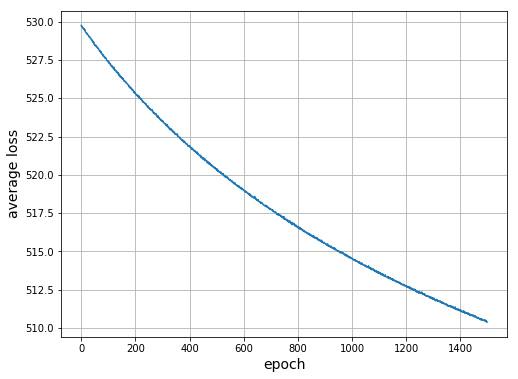

In [62]:
# plot the convergence of the estimated loss function

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(losses)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [66]:
nrof_correct = 0.0
nrof_total = len(X_test)
for i, (data, label) in enumerate(test_data):
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    y_pred = net(data)
    y_pred = (nd.sign(y_pred) + 1) / 2 # -1, 0, 1
    nrof_correct += nd.sum(y_pred == label)
print('Accuracy: {:.4} ({}/{})'.format(nrof_correct.asscalar() / nrof_total, nrof_correct.asscalar(), nrof_total))

Accuracy: 0.8416 (26052.0/30956)
